### ***General unbounded outcome from COVID-19 case model***

$$O_a(t) \sim NB(o_a(t), \, o_a(t) + \frac{o_a^2(t)}{\phi})$$
$$ o_a(t) = \sum_{k=1}^t n_a(k) T(t-k) COR_a(k)$$
$$ COR_a (t) = (1-p_a(t)) COR_{a,0} + p_a(t) RR_a COR_{a,0} $$

In [158]:
!pip install pystan==2.19.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [159]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.dates as mdates
from scipy import stats

import pystan as ps
import arviz as az
import pickle


import seaborn as sns
sns.set(style='ticks')
sns.set_theme()

import datetime
from sklearn.linear_model import LinearRegression

import re
from scipy.special import gamma, factorial
import multiprocessing
multiprocessing.set_start_method("fork", force=True)

In [160]:
class OutcomeModel:
    def __init__(self, data_folder, stan_folder):
        self.data_folder = data_folder
        self.data = pd.read_csv(data_folder+"OutcomesData.csv")
        age_group = self.data['age_group'].unique()

        cases_data   = self.data[self.data['outcome'] == 'new_cases']
        cases_dates = cases_data['date'].unique()
        cases_age = pd.DataFrame()
        cases_age['age_group'] =  age_group
        for date in cases_dates:
            cases_age[date] = cases_data[cases_data['date']==date].groupby('age_group', sort=False).sum()['quantity'].to_numpy()
        
        cases_age = cases_age.set_index('age_group')

        cas_age = pd.DataFrame()
        cas_age['0-24'] = cases_age.T['0-4'] + cases_age.T['5-9'] + cases_age.T['10-15'] + cases_age.T['16-24']
        cas_age['25-34'] = cases_age.T['25-34'] 
        cas_age['35-44'] = cases_age.T['35-44'] 
        cas_age['45-54'] = cases_age.T['45-54'] 
        cas_age['55-64'] = cases_age.T['55-64'] 
        cas_age['65-74'] = cases_age.T['65-74'] 
        cas_age['+75'] = cases_age.T['75-84'] + cases_age.T['85+']  
        cas_age = cas_age.T

        self.stan_folder = stan_folder
        sampler = ps.StanModel(file=self.stan_folder+"modelExpAgeOutcome.stan")
        sampler_vac = ps.StanModel(file=self.stan_folder+"modelExpVaccineRR.stan")
        sampler_all_vac = ps.StanModel(file=self.stan_folder+"modelExpAllVac.stan")
        self.sampler = sampler 
        self.sampler_vac = sampler_vac
        self.sampler_all_vac = sampler_all_vac
        self.age_group = np.array(cas_age.index)
        self.age_group_ini = age_group
        self.cases_age = cas_age 
        self.outcome_age = {
            'deaths': None,
            'entries_Hosp': None,
            'entries_ICU': None
        }
        self.fits = {
            'deaths': None,
            'entries_Hosp': None,
            'entries_ICU': None
        }
        self.fits_all = {
            'deaths': None,
            'entries_Hosp': None,
            'entries_ICU': None
        }
        self.fits_vac = {
            'deaths': None,
            'entries_Hosp': None,
            'entries_ICU': None
        }
        self.fits_all_vac = {
            'deaths': None,
            'entries_Hosp': None,
            'entries_ICU': None
        }
        self.cor = {
            'deaths': None,
            'entries_Hosp': None,
            'entries_ICU': None
        }
        self.phi = {
            'deaths': None,
            'entries_Hosp': None,
            'entries_ICU': None
        }
        self.time_cases_to_outcome = {
            'deaths': None,
            'entries_Hosp': None,
            'entries_ICU': None
        }
        self.mean_tot_cor = {
            'deaths': None,
            'entries_Hosp': None,
            'entries_ICU': None
        }
        self.str_parser = {
            'deaths': 'deaths',
            'entries_Hosp': 'hospitalizations',
            'entries_ICU': 'ICU'
        }
        self.COR_parser = {
            'deaths': 'CFR',
            'entries_Hosp': 'CHR',
            'entries_ICU': 'CIR'
        }
        pass 

           
    def sample_outcome_no_vac(self, outcome_kind, t0_cases, tf_cases, t0_outcome, tf_outcome, t0_pred_outcome, tf_pred_outcome):
        outcome_data = self.data[self.data['outcome'] == outcome_kind]
        outcome_dates = outcome_data['date'].unique()
        outcome_age = pd.DataFrame()
        outcome_age['age_group'] =  self.age_group_ini

        for date in outcome_dates:
            outcome_age[date] = outcome_data[outcome_data['date']==date].groupby('age_group', sort=False).sum()['quantity'].to_numpy()

        outcome_age = outcome_age.set_index('age_group')

        out_age = pd.DataFrame()
        out_age['0-24'] = outcome_age.T['0-4'] + outcome_age.T['5-9'] + outcome_age.T['10-15'] + outcome_age.T['16-24']
        out_age['25-34'] = outcome_age.T['25-34'] 
        out_age['35-44'] = outcome_age.T['35-44'] 
        out_age['45-54'] = outcome_age.T['45-54'] 
        out_age['55-64'] = outcome_age.T['55-64'] 
        out_age['65-74'] = outcome_age.T['65-74'] 
        out_age['+75'] = outcome_age.T['75-84'] + outcome_age.T['85+']  
        out_age = out_age.T

        outcome_age = out_age
        self.outcome_age[outcome_kind] = outcome_age

        tf_pred_cases = tf_pred_outcome
        cases = self.cases_age.loc[:,t0_cases:tf_cases].values
        outcome = outcome_age.loc[:,t0_outcome:tf_outcome].values.astype(int)
        outcome_pred_obs = outcome_age.loc[:,t0_pred_outcome:tf_pred_outcome].values.astype(int)
        cases_pred = self.cases_age.loc[:,t0_cases:tf_pred_cases].values

        n_days_cases = cases.shape[1]
        n_days_outcome = outcome.shape[1]
        n_days_outcome_pred = outcome_pred_obs.shape[1]
        n_days_cases_pred = cases_pred.shape[1]

        n_age = cases.shape[0]
        dic_data = {'nAge': n_age, 
               'nDaysCases': n_days_cases, 
               'nDaysOutcome': n_days_outcome, 
               'nDaysCasesPred':n_days_cases_pred , 
               'nDaysOutcomePred':n_days_outcome_pred, 
               'outcome': outcome, 
               'cases': cases, 
               'casesPred':cases_pred}

        fit = self.sampler.sampling(data=dic_data, iter=1000, chains=8, warmup=500, thin=1, seed=101, n_jobs=4, init_r=2, control={'adapt_delta':0.8})
        self.fits[outcome_kind] = fit
        pass

        
    def results_no_vac(self, outcome_kind, t0_cases, tf_cases, t0_outcome, tf_outcome, t0_pred_outcome, tf_pred_outcome, plot=True):
        outcome = self.fits[outcome_kind].extract()['OutcomePredicted']
        q1 = np.quantile(outcome, 0.975,  axis=0)
        q2 = np.quantile(outcome, 0.025,  axis=0)

        cor_samples = self.fits[outcome_kind].extract()['cor']
        mean_cor = np.mean(self.fits[outcome_kind].extract()['cor'], axis=0)
        phi_samples = self.fits[outcome_kind].extract()['phi']
        phi_mean = np.mean(self.fits[outcome_kind].extract()['phi'], axis=0)

        time_cases_to_outcome = np.mean(1/(self.fits[outcome_kind].extract()['lambda'])).round(2)
        hdi_time_cases_to_outcome = az.hdi(1/self.fits[outcome_kind].extract()['lambda'],hdi_prob=0.95)
        outcome_pred_mean = np.mean(outcome, axis=0)
        mean_outcome_pred = pd.DataFrame(outcome_pred_mean, columns=self.outcome_age[outcome_kind].loc[:,t0_outcome:tf_pred_outcome].columns, index= self.outcome_age[outcome_kind].index)
        self.cor[outcome_kind] = cor_samples 
        self.phi[outcome_kind] = phi_samples
        self.time_cases_to_outcome[outcome_kind] = time_cases_to_outcome
        print(f'Mean time from cases to overcome:  {time_cases_to_outcome} days (HDI (95%) [{hdi_time_cases_to_outcome[0].round(2)}, {hdi_time_cases_to_outcome[1].round(2)}])')
        print()

        age_interval = [0, 25, 35, 45, 55, 65, 75, 130]
        demo = pd.read_csv(self.data_folder+'/ine_estimaciones-y-proyecciones-2002-2035_base-2017_region_base.csv')
        demo['age_group'] = pd.cut(x=demo['Edad'], bins=age_interval, right=False)
        demography = demo.groupby('age_group').sum()[['a2020','a2021','a2022']].rename(columns={'a2020':'2020','a2021':'2021','a2022':'2022'}).reset_index()
        age_group = pd.cut(x=demo['Edad'], bins=age_interval, right=False).unique()

        new_index = np.zeros(len(demography['age_group']), dtype=object)
        for i in range(len(demography['age_group'])):
            left, rigth = demography['age_group'][i].left, demography['age_group'][i].right-1
            new_index[i] = str(left)+'-'+str(rigth)
        new_index[-1] = '+75'

        pop = demography.copy()
        pop = pop.drop(columns=['age_group'])
        pop = pop.set_index(new_index)

        population = pop['2021'].values
        mean_total_cor = (mean_cor*population/population.sum()).sum()*100
        self.mean_tot_cor[outcome_kind] = mean_total_cor
        print(f'{self.COR_parser[outcome_kind]} en Chile between {t0_cases} and {tf_cases}: {mean_total_cor.round(2)} %')
        print()

        cases = self.cases_age.loc[:,t0_cases:tf_cases].values
        outcome = self.outcome_age[outcome_kind].loc[:,t0_outcome:tf_outcome].values.astype(int)
        outcome_pred_obs = self.outcome_age[outcome_kind].loc[:,t0_pred_outcome:tf_pred_outcome].values.astype(int)
        cases_pred = self.cases_age.loc[:,t0_cases:tf_pred_outcome].values

        n_days_cases = cases.shape[1]
        n_days_outcome = outcome.shape[1]
        n_days_outcome_pred = outcome_pred_obs.shape[1]
        n_days_cases_pred = cases_pred.shape[1]

        if plot:
            rows, cols = 2, 4
            fig, ax = plt.subplots(rows, cols, figsize=(25,15))
            i=0
            j=0
            k = 0
            dates_obs = pd.to_datetime(self.outcome_age[outcome_kind].loc[:,t0_outcome: tf_outcome].columns, format="%Y-%m-%d")
            dates_pred = pd.to_datetime(self.outcome_age[outcome_kind].loc[:,t0_pred_outcome:tf_pred_outcome].columns, format="%Y-%m-%d")

            total_outcome_obs = np.zeros(len(dates_obs)+len(dates_pred))  


            for a in mean_outcome_pred.index:
                ax[i,j].plot(dates_obs, self.outcome_age[outcome_kind].loc[a,t0_outcome:tf_outcome], color='C0', label='obs train')
                ax[i,j].plot(dates_pred, self.outcome_age[outcome_kind].loc[a,t0_pred_outcome:tf_pred_outcome], color='C1', label='obs test')

                ax[i,j].plot(dates_obs, mean_outcome_pred.loc[a,t0_outcome:tf_outcome], color='C2', label='validation')
                ax[i,j].fill_between(dates_obs, q1[k,:n_days_outcome],  q2[k,:n_days_outcome], alpha=0.3, color='C2')

                ax[i,j].plot(dates_pred, mean_outcome_pred.loc[a,t0_pred_outcome:tf_pred_outcome], color='C3', label='prediction')
                ax[i,j].fill_between(dates_pred, q1[k,n_days_outcome:n_days_outcome_pred+n_days_outcome],  q2[k,n_days_outcome:n_days_outcome+n_days_outcome_pred], alpha=0.3, color='C3')

                ax[i,j].set_title(f'COVID-19 {self.str_parser[outcome_kind]}: age group {a}')
                ax[i,j].legend()
                
                my_fmt = mdates.DateFormatter('%b-%y')
                ax[i,j].xaxis.set_major_formatter(my_fmt)
                k += 1
                i = k//cols
                j = k % cols

            fig, ax = plt.subplots(1,1, figsize=(20,10))
            ax.plot([str(a) for a in mean_outcome_pred.index], np.log(mean_cor))
            ax.set_title(f'Log {self.COR_parser[outcome_kind]} by age in Chile between {t0_cases} and {tf_cases}')
        pass         

    def sample_outcome_vac(self, outcome_kind, t0v_cases, tfv_cases, t0v_outcome, tfv_outcome):
        age_interval = [0, 25, 35, 45, 55, 65, 75, 130]

        demo = pd.read_csv(self.data_folder+'/ine_estimaciones-y-proyecciones-2002-2035_base-2017_region_base.csv')
        demo['age_group'] = pd.cut(x=demo['Edad'], bins=age_interval, right=False)
        demography = demo.groupby('age_group').sum()[['a2020','a2021','a2022']].rename(columns={'a2020':'2020','a2021':'2021','a2022':'2022'}).reset_index()
        age_group = pd.cut(x=demo['Edad'], bins=age_interval, right=False).unique()

        new_index = np.zeros(len(demography['age_group']), dtype=object)
        for i in range(len(demography['age_group'])):
            left, rigth = demography['age_group'][i].left, demography['age_group'][i].right-1
            new_index[i] = str(left)+'-'+str(rigth)
        new_index[-1] = '+75'

        pop = demography.copy()
        pop = pop.drop(columns=['age_group'])
        pop = pop.set_index(new_index)

        population = pop['2021'].values
        
        # two_doses = pd.read_csv('https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto78/vacunados_edad_fecha_2daDosis.csv')
        # unique_dose = pd.read_csv('https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto78/vacunados_edad_fecha_UnicaDosis.csv')
        third_dose = pd.read_csv('https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto78/vacunados_edad_fecha_Refuerzo.csv')
        #vaccinated_tmp = two_doses.iloc[:,1:].fillna(0)+unique_dose.iloc[:,1:].fillna(0)
        vaccinated_tmp = third_dose.iloc[:,1:].fillna(0)
        # vaccinated = pd.merge(two_doses[['Edad']],vaccinated_tmp, left_index=True, right_index=True).rename(columns={'Edad':'age_group'})
        # vaccinated['age_group'] = pd.cut(x=vaccinated['age_group'], bins=age_interval, right=False)
        # vaccinated_by_age = vaccinated.groupby('age_group').sum().reset_index()

        vaccinated = pd.merge(third_dose[['Edad']],vaccinated_tmp, left_index=True, right_index=True).rename(columns={'Edad':'age_group'})
        vaccinated['age_group'] = pd.cut(x=vaccinated['age_group'], bins=age_interval, right=False)
        vaccinated_by_age = vaccinated.groupby('age_group').sum().reset_index()

        prop_vaccinated_by_age = pd.merge(vaccinated_by_age['age_group'], vaccinated_by_age.iloc[:,1:].div(demography['2021'],axis=0),left_index=True, right_index=True )
        new_index = np.zeros(len(demography['age_group']), dtype=object)
        for i in range(len(demography['age_group'])):
            left, rigth = demography['age_group'][i].left, demography['age_group'][i].right-1
            new_index[i] = str(left)+'-'+str(rigth)
        new_index[-1] = '+85'
        vaccinated_by_age = vaccinated_by_age.drop(columns=['age_group'])
        vaccinated_by_age = vaccinated_by_age.set_index(new_index) 
        prop_vaccinated_by_age = prop_vaccinated_by_age.drop(columns=['age_group'])
        prop_vaccinated_by_age = prop_vaccinated_by_age.set_index(new_index) 

        prop_no_vaccinated_by_age = (1-prop_vaccinated_by_age.iloc[:,1:])
        prop_v = prop_vaccinated_by_age.loc[:,t0v_cases:tfv_cases].values.T.cumsum(axis=0)
        prop_nv = prop_no_vaccinated_by_age.loc[:,t0v_cases:tfv_cases].values.T
        cases_v = self.cases_age.loc[:,t0v_cases:tfv_cases].values.T
        outcome_v = self.outcome_age[outcome_kind].loc[:,t0v_outcome:tfv_outcome].values.astype(int).T

        dicV = {
            'lambda': 1/self.time_cases_to_outcome[outcome_kind],
            'phi': np.mean(self.phi[outcome_kind], axis=0),
            'nAge': len(self.age_group),
            'propVaccinated': prop_v,
            'propNoVaccinated': prop_nv, 
            'cor0': np.mean(self.cor[outcome_kind], axis=0),
            'population': population,
            'nDaysCases': cases_v.shape[0],
            'nDaysOutcome':outcome_v.shape[0],
            'cases':cases_v, 
            'outcome':outcome_v
            }

        fit = self.sampler_vac.sampling(data=dicV, iter = 1000, chains = 4, warmup = 500, thin = 1, seed = 101, n_jobs = 4, control = {'adapt_delta':0.99})
        self.fits_vac[outcome_kind] = fit

        pass

    def results_vac(self, outcome_kind, t0v_cases, tfv_cases, t0v_outcome, tfv_outcome, plot=True):
        ou = self.fits_vac[outcome_kind].extract()['OutcomePredicted']
        outcome_pred_mean = np.mean(ou, axis=0)
        mean_outcome_pred = pd.DataFrame(outcome_pred_mean, columns=self.outcome_age[outcome_kind].loc[:,t0v_outcome:tfv_outcome].columns, index= self.outcome_age[outcome_kind].index)

        q1 = np.quantile(ou, 0.975,  axis=0)
        q2 = np.quantile(ou, 0.025,  axis=0)

        plot = True

        cases = self.cases_age.loc[:,t0v_cases:tfv_cases].values
        outcome = self.outcome_age[outcome_kind].loc[:,t0v_outcome:tfv_outcome].values.astype(int)
        outcome_pred_obs = self.outcome_age[outcome_kind].loc[:,t0v_outcome:tfv_outcome].values.astype(int)
        cases_pred = self.cases_age.loc[:,t0v_cases:tfv_pred_outcome].values

        n_days_cases = cases.shape[1]
        n_days_outcome = outcome.shape[1]
        n_days_outcome_pred = outcome_pred_obs.shape[1]
        n_days_cases_pred = cases_pred.shape[1]

        if plot:
            rows, cols = 2, 4
            fig, ax = plt.subplots(rows, cols, figsize=(25,15))
            i=0
            j=0
            k = 0
            dates_obs = pd.to_datetime(self.outcome_age[outcome_kind].loc[:,t0v_outcome: tfv_outcome].columns, format="%Y-%m-%d")
            dates_pred = pd.to_datetime(self.outcome_age[outcome_kind].loc[:,t0v_outcome:tfv_outcome].columns, format="%Y-%m-%d")

            total_outcome_obs = np.zeros(len(dates_obs))
            total_outcome_pred = np.zeros(len(dates_obs))
            q1_total, q2_total = np.zeros(len(dates_obs)), np.zeros(len(dates_obs))

            for a in mean_outcome_pred.index:
                total_outcome_obs += self.outcome_age[outcome_kind].loc[a,t0v_outcome:tfv_outcome] 
                total_outcome_pred += mean_outcome_pred.loc[a,t0v_outcome:tfv_outcome] 
                q1_total += q1[k] 
                q2_total += q2[k] 

                ax[i,j].plot(dates_pred, self.outcome_age[outcome_kind].loc[a,t0v_outcome:tfv_outcome], color='C1', label='obs test')

                ax[i,j].plot(dates_pred, mean_outcome_pred.loc[a,t0v_outcome:tfv_outcome], color='C3', label='prediction')
                ax[i,j].fill_between(dates_pred, q1[k],  q2[k], alpha=0.3, color='C3')

                ax[i,j].set_title(f'COVID-19 {self.str_parser[outcome_kind]}: age group {a}')
                ax[i,j].legend()
                
                my_fmt = mdates.DateFormatter('%b-%y')
                ax[i,j].xaxis.set_major_formatter(my_fmt)
                k += 1
                i = k//cols
                j = k % cols

            ax[i,j].plot(dates_pred, total_outcome_obs, color='C1', label='obs test')

            ax[i,j].plot(dates_pred, total_outcome_pred, color='C3', label='prediction')
            ax[i,j].fill_between(dates_pred, q1_total,  q2_total, alpha=0.3, color='C3')

            ax[i,j].set_title(f'COVID-19 {self.str_parser[outcome_kind]}: total population')
            ax[i,j].legend()


        print()

        rr_samples = self.fits_vac[outcome_kind].extract()['RR']
        mean_rr = np.mean(rr_samples, axis=0)
        ve = (1 - mean_rr)*100
        ve_ic = (1 - az.hdi(rr_samples, hdi_prob=0.95))*100
        ages_str = np.array([str(a)  for a in self.age_group])


        fig, ax = plt.subplots(figsize=(20,10))

        ax.scatter(range(len(ve)), ve, label='mean')
        ax.vlines(x=np.array(ages_str), ymin=ve_ic[:,1], ymax=ve_ic[:,0], label='95% CI')

        if outcome_kind == "deaths":
            
            ax.set_title(f'Effectiveness to prevent death if COVID-19 case between {t0v_outcome} and {tfv_outcome}')
            ax.set_ylabel('Effectiveness to prevent death if COVID-19 case (%)')
            ax.set_xlabel('Age group')
            for i in range(len(ve)):
                if ve[i] > 0.9:
                    dist = -5
                else:
                    dist = 5
                ax.text(x=range(len(ve))[i], y=ve[i]+dist, s=str(ve[i].round())+'%', color='C0')
            ax.legend(loc='lower right')
        if outcome_kind == "entries_Hosp":
            ax.set_title(f'Effectiveness to prevent hospitalization if COVID-19 case between {t0v_outcome} and {tfv_outcome}')
            ax.set_ylabel('Effectiveness to prevent hospitalization if COVID-19 case(%)')
            ax.set_xlabel('Age group')
            for i in range(len(ve)):
                if ve[i] > 0.9:
                    dist = -5
                else:
                    dist = 5
                ax.text(x=range(len(ve))[i], y=ve[i]+dist, s=str(ve[i].round())+'%', color='C0')
            ax.legend(loc='lower right')
        if outcome_kind == "entries_ICU":
            ax.set_title(f'Effectiveness to prevent ICU if COVID-19 case between {t0v_outcome} and {tfv_outcome}')
            ax.set_ylabel('Effectiveness to prevent ICU if COVID-19 case (%)')
            ax.set_xlabel('Age group')
            for i in range(len(ve)):
                if ve[i] > 0.9:
                    dist = -5
                else:
                    dist = 5
                ax.text(x=range(len(ve))[i], y=ve[i]+dist, s=str(ve[i].round())+'%', color='C0')
            ax.legend(loc='lower right')
        pass

    def sample_all_no_vac(self, outcome_kind, t0_cases, tf_cases, t0_outcome, tf_outcome, t0_pred_outcome, tf_pred_outcome):
        outcome_data = self.data[self.data['outcome'] == outcome_kind]
        outcome_dates = outcome_data['date'].unique()
        outcome_age = pd.DataFrame()
        outcome_age['age_group'] =  self.age_group_ini

        for date in outcome_dates:
            outcome_age[date] = outcome_data[outcome_data['date']==date].groupby('age_group', sort=False).sum()['quantity'].to_numpy()

        outcome_age = outcome_age.set_index('age_group')
        self.outcome_age[outcome_kind] = outcome_age

        tf_pred_cases = tf_pred_outcome
        cases, outcome, outcome_pred_obs, cases_pred = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
        cases['all'] = self.cases_age.sum()[t0_cases:tf_cases].values
        outcome['all'] = outcome_age.sum()[t0_outcome:tf_outcome].values.astype(int)
        outcome_pred_obs['all'] = outcome_age.sum()[t0_pred_outcome:tf_pred_outcome].values.astype(int)
        cases_pred['all'] = self.cases_age.sum()[t0_cases:tf_pred_cases].values

        n_days_cases = cases.shape[0]
        n_days_outcome = outcome.shape[0]
        n_days_outcome_pred = outcome_pred_obs.shape[0]
        n_days_cases_pred = cases_pred.shape[0]

        n_age = 1
        dic_data = {'nAge': n_age, 
               'nDaysCases': n_days_cases, 
               'nDaysOutcome': n_days_outcome, 
               'nDaysCasesPred':n_days_cases_pred , 
               'nDaysOutcomePred':n_days_outcome_pred, 
               'outcome': outcome.T, 
               'cases': cases.T, 
               'casesPred':cases_pred.T}

        fit = self.sampler.sampling(data=dic_data, iter=1000, chains=8, warmup=500, thin=1, seed=101, n_jobs=4, init_r=2, control={'adapt_delta':0.99})
        self.fits_all[outcome_kind] = fit
        pass

    def results_all_no_vac(self, outcome_kind, t0_cases, tf_cases, t0_outcome, tf_outcome, t0_pred_outcome, tf_pred_outcome, plot=True):
        out = self.fits_all[outcome_kind].extract()['OutcomePredicted']
        outcome = self.fits_all[outcome_kind].extract()['OutcomePredicted'].mean(axis=0)[0]
        q1 = np.quantile(out, 0.975,  axis=0)[0]
        q2 = np.quantile(out, 0.025,  axis=0)[0]

        cor_samples = self.fits_all[outcome_kind].extract()['cor']
        mean_cor = np.mean(self.fits_all[outcome_kind].extract()['cor'], axis=0)
        phi_samples = self.fits_all[outcome_kind].extract()['phi']
        phi_mean = np.mean(self.fits_all[outcome_kind].extract()['phi'], axis=0)

        time_cases_to_outcome = np.mean(1/(self.fits_all[outcome_kind].extract()['lambda'])).round(2)
        hdi_time_cases_to_outcome = az.hdi(1/self.fits_all[outcome_kind].extract()['lambda'],hdi_prob=0.95)
        outcome_pred_mean = np.mean(outcome, axis=0)
        self.cor[outcome_kind] = cor_samples 
        self.phi[outcome_kind] = phi_samples
        self.time_cases_to_outcome[outcome_kind] = time_cases_to_outcome

        print("Estimated parameters (95% CI)")

        lambda_mean = model.fits_all[outcome_kind].extract()['lambda'].mean().round(3)
        lambda_hdi_1, lambda_hdi_2 = az.hdi(model.fits_all[outcome_kind].extract()['lambda'],hdi_prob=0.95)
        print(f"lambda: {lambda_mean} ({lambda_hdi_1.round(3)}, {lambda_hdi_2.round(3)})")

        cor_mean = model.fits_all[outcome_kind].extract()['cor'].mean()*100
        cor_hdi_1, cor_hdi_2 = az.hdi(model.fits_all[outcome_kind].extract()['cor'],hdi_prob=0.95)[0]*100
        print(f"cor: {cor_mean.round(2)} ({cor_hdi_1.round(2)}, {cor_hdi_2.round(2)})")

        phi_mean = model.fits_all[outcome_kind].extract()['phi'].mean().round(2)
        phi_hdi_1, phi_hdi_2 = az.hdi(model.fits_all[outcome_kind].extract()['phi'],hdi_prob=0.95)
        print(f"phi: {phi_mean} ({phi_hdi_1.round(2)}, {phi_hdi_2.round(2)})")

        print()

        print(f'Mean time from cases to overcome:  {time_cases_to_outcome} days (HDI (95%) [{hdi_time_cases_to_outcome[0].round(2)}, {hdi_time_cases_to_outcome[1].round(2)}])')
        print()

        perc_cor = mean_cor[0]*100
    
        print(f'{self.COR_parser[outcome_kind]} en Chile between {t0_cases} and {tf_cases}: {perc_cor.round(2)} %')
        print()

        cases = self.cases_age.loc[:,t0_cases:tf_cases].values
        outcome_obs = self.outcome_age[outcome_kind].loc[:,t0_outcome:tf_outcome].values.astype(int)
        outcome_pred_obs = self.outcome_age[outcome_kind].loc[:,t0_pred_outcome:tf_pred_outcome].values.astype(int)
        cases_pred = self.cases_age.loc[:,t0_cases:tf_pred_outcome].values


        if plot:
            dates_obs = pd.to_datetime(self.outcome_age[outcome_kind].loc[:,t0_outcome: tf_outcome].columns, format="%Y-%m")
            dates_pred = pd.to_datetime(self.outcome_age[outcome_kind].loc[:,t0_pred_outcome:tf_pred_outcome].columns, format="%Y-%m")

            n_days_outcome_test = len(dates_obs)
            n_days_outcome_pred = len(dates_pred)

            fig = plt.figure(figsize=(9,7))
            ax = fig.add_subplot(111)

            ax.plot(dates_obs, self.outcome_age[outcome_kind].sum()[t0_outcome:  tf_outcome], color='C0', label='obs train')
            ax.plot(dates_pred, self.outcome_age[outcome_kind].sum()[t0_pred_outcome:  tf_pred_outcome], color='C1', label='obs test')

            ax.plot(dates_obs, outcome[:n_days_outcome_test], color='C2', label='validation')
            ax.plot(dates_pred, outcome[n_days_outcome_test:n_days_outcome_test+n_days_outcome_pred], color='C3', label='prediction')

            ax.fill_between(dates_obs, q1[:n_days_outcome_test],  q2[:n_days_outcome_test], alpha=0.3, color='C2')
            ax.fill_between(dates_pred, q1[n_days_outcome_test:n_days_outcome_test+n_days_outcome_pred],  q2[n_days_outcome_test:n_days_outcome_test+n_days_outcome_pred], alpha=0.3, color='C3')

            ax.legend()
            my_fmt = mdates.DateFormatter('%b-%y')
            ax.xaxis.set_major_formatter(my_fmt)
            ax.set_title(f'COVID-19 {self.str_parser[outcome_kind]}: total population')
            ax.set_xlabel("Date")
            ax.set_ylabel(f"{self.str_parser[outcome_kind]}")
            plt.show()
        pass

    def sample_all_vac(self, outcome_kind, t0v_cases, tfv_cases, t0v_outcome, tfv_outcome, dose = 'third'):
        demo = pd.read_csv(self.data_folder+'/ine_estimaciones-y-proyecciones-2002-2035_base-2017_region_base.csv')
        tot_pop = demo['a2021'].sum()

        if dose=='third':
            third_dose = pd.read_csv('https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto78/vacunados_edad_fecha_Refuerzo.csv')
            vaccinated_tmp = third_dose.iloc[:,1:].fillna(0)
            vaccinated = vaccinated_tmp.sum()[t0v_cases:tfv_cases]

        else:
            two_doses = pd.read_csv('https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto78/vacunados_edad_fecha_2daDosis.csv')
            unique_dose = pd.read_csv('https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto78/vacunados_edad_fecha_UnicaDosis.csv')
            vaccinated_tmp = two_doses.iloc[:,1:].fillna(0)+unique_dose.iloc[:,1:].fillna(0)
            vaccinated = vaccinated_tmp.sum()[t0v_cases:tfv_cases]
        
        prop_vaccinated = vaccinated/tot_pop
        prop_vaccinated = prop_vaccinated.values.cumsum()
        prop_no_vaccinated = 1 - prop_vaccinated

        cases_v = self.cases_age.loc[:,t0v_cases:tfv_cases].values.sum(axis=0).astype(int)
        outcome_v = self.outcome_age[outcome_kind].loc[:,t0v_outcome:tfv_outcome].values.sum(axis=0).astype(int)

        dicV = {
            'lambda': 1/model.time_cases_to_outcome[outcome_kind],
            'phi': np.mean(model.phi[outcome_kind], axis=0),
            'nAge': 1,
            'propVaccinated': prop_vaccinated,
            'propNoVaccinated': prop_no_vaccinated, 
            'cor0': np.mean(model.cor[outcome_kind], axis=0)[0],
            'population': tot_pop,
            'nDaysCases': cases_v.shape[0],
            'nDaysOutcome':outcome_v.shape[0],
            'cases': cases_v, 
            'outcome': outcome_v
            }

        fit = self.sampler_all_vac.sampling(data=dicV, iter = 1000, chains = 8, warmup = 500, thin = 1, seed = 101, n_jobs = 4, control = {'adapt_delta':0.99})
        self.fits_all_vac[outcome_kind] = fit

        pass

    def results_all_vac(self, outcome_kind, t0v_cases, tfv_cases, t0v_outcome, tfv_outcome, plot=True):
        out = self.fits_all_vac[outcome_kind].extract()['OutcomePredicted']
        outcome = self.fits_all_vac[outcome_kind].extract()['OutcomePredicted'].mean(axis=0)
        q1 = np.quantile(out, 0.975,  axis=0)
        q2 = np.quantile(out, 0.025,  axis=0)

        cases = self.cases_age.loc[:,t0_cases:tf_cases].values
        outcome_obs = self.outcome_age[outcome_kind].loc[:,t0v_outcome:tfv_outcome].values.astype(int)
        outcome_pred_obs = self.outcome_age[outcome_kind].loc[:,t0v_pred_outcome:tfv_pred_outcome].values.astype(int)
        cases_pred = self.cases_age.loc[:,t0_cases:tf_pred_outcome].values

        rr = model.fits_all_vac[outcome_kind].extract()['RR']
        rr_m = np.mean(rr, axis=0)

        print("Estimated RR:")
        rr_mean = model.fits_all_vac[outcome_kind].extract()['RR'].mean().round(3)*100
        rr_1, rr_2 = az.hdi(model.fits_all_vac[outcome_kind].extract()['RR'],hdi_prob=0.95)*100
        print(f"RR: {rr_mean.round(3)} ({rr_1.round(3)}, {rr_2.round(3)})")
        print()
        
        print(f"Effectiveness: {1-rr_m}")
        print()

        if True:
            fig = plt.figure(figsize=(9,7))
            ax = fig.add_subplot(111)
            
            dates_obs = pd.to_datetime(self.outcome_age[outcome_kind].loc[:,t0v_outcome: tfv_outcome].columns, format="%Y-%m")
            dates_pred = pd.to_datetime(self.outcome_age[outcome_kind].loc[:,t0v_pred_outcome:tfv_pred_outcome].columns, format="%Y-%m")

            n_days_outcome_test = len(dates_obs)
            n_days_outcome_pred = len(dates_pred)

            ax.plot(dates_obs, self.outcome_age[outcome_kind].sum()[t0v_outcome:  tfv_outcome], color='C0', label='obs train')
            #ax.plot(dates_pred, self.outcome_age[outcome_kind].sum()[t0v_pred_outcome:  tfv_pred_outcome], color='C1', label='obs test')

            ax.fill_between(dates_obs, q1[:n_days_outcome_test],  q2[:n_days_outcome_test], alpha=0.3, color='C2')
            #ax.fill_between(dates_pred, q1[n_days_outcome_test:n_days_outcome_test+n_days_outcome_pred],  q2[n_days_outcome_test:n_days_outcome_test+n_days_outcome_pred], alpha=0.3, color='C3')


            ax.plot(dates_obs, outcome[:n_days_outcome_test], color='C2', label='validation')
            #ax.plot(dates_pred, outcome[n_days_outcome_test:], color='C3', label='prediction')
            ax.legend()
            my_fmt = mdates.DateFormatter('%b-%y')
            ax.xaxis.set_major_formatter(my_fmt)
            ax.set_title(f'COVID-19 {self.str_parser[outcome_kind]}: total population')
            ax.set_xlabel("Date")
            ax.set_ylabel(f"{self.str_parser[outcome_kind]}")
            plt.show()
        pass

    def simulate_outcome(self, outcome_kind, t0v_cases, tfv_cases, t0v_outcome, tfv_outcome, iter = 1000, RR_aux = 1.1, R0_prop = 1,  dose = 'third', plot=True, comparComp=True):
        predCasesAcum = pd.read_csv(path+'casesNoVac.csv')
        predCasesAcum = predCasesAcum.set_index('dates')
        predCasesAcum = predCasesAcum - predCasesAcum.T[t0v_cases]
        acumCas = predCasesAcum.loc[t0v_cases:tfv_cases].values.astype(int)
        acumCas = acumCas.reshape(acumCas.shape[0])

        ini_index = np.where(predCasesAcum.index==t0v_cases)[0][0] - 1

        outcome = self.fits_all_vac[outcome_kind].extract()['OutcomePredicted'].mean(axis=0)
        
        dailyCas = np.zeros_like(acumCas)
        dailyCas[0] = acumCas[0] - predCasesAcum.T[predCasesAcum.index[ini_index]].values[0]

        for i in range(1, len(dailyCas)):
            dailyCas[i] = acumCas[i] - acumCas[i-1]

        cor = self.cor[outcome_kind].mean()
        lamb = 1/self.time_cases_to_outcome[outcome_kind]
        phi = self.phi[outcome_kind].mean()

        if RR_aux <= 1:
            RR = RR_aux

        else:
            RR = self.fits_all_vac[outcome_kind].extract()['RR'].mean()

        cases_v = self.cases_age.loc[:,t0v_cases:tfv_cases].values.sum(axis=0).astype(int)
        outcome_v = self.outcome_age[outcome_kind].loc[:,t0v_outcome:tfv_outcome].values.sum(axis=0).astype(int)

        demo = pd.read_csv(self.data_folder+'/ine_estimaciones-y-proyecciones-2002-2035_base-2017_region_base.csv')
        tot_pop = demo['a2021'].sum()

        if dose=='third':
            third_dose = pd.read_csv('https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto78/vacunados_edad_fecha_Refuerzo.csv')
            vaccinated_tmp = third_dose.iloc[:,1:].fillna(0)
            vaccinated = vaccinated_tmp.sum()[t0v_cases:tfv_cases]

        else:
            two_doses = pd.read_csv('https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto78/vacunados_edad_fecha_2daDosis.csv')
            unique_dose = pd.read_csv('https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto78/vacunados_edad_fecha_UnicaDosis.csv')
            vaccinated_tmp = two_doses.iloc[:,1:].fillna(0)+unique_dose.iloc[:,1:].fillna(0)
            vaccinated = vaccinated_tmp.sum()[t0v_cases:tfv_cases]

        prop_vaccinated = vaccinated/tot_pop
        prop_vaccinated = prop_vaccinated.values.cumsum()
        prop_no_vaccinated = 1 - prop_vaccinated

        conv_no_vac = np.zeros(len(cases_v)) 
        conv_vac = np.zeros(len(cases_v)) 
        conv_no_vac_sir = np.zeros(len(cases_v)) 

        COR_vac = np.zeros(len(cases_v))
        COR_vac[0] = (1-prop_vaccinated[0])*cor + prop_vaccinated[0]*cor*RR

        conv_no_vac[0] = stats.expon(lamb).pdf(0)*cor*cases_v[0] 
        conv_no_vac[0] = stats.expon(lamb).pdf(0)*COR_vac[0]*cases_v[0] 
        conv_no_vac_sir[0] = 0

        for i in range(1,len(cases_v)):
            COR_vac[i] = (1-prop_vaccinated[i])*cor + prop_vaccinated[i]*cor*RR
            for j in range(i):
                conv_no_vac[i] += stats.expon(lamb).pdf(i-j)*cor*cases_v[j]*R0_prop
                conv_no_vac_sir[i] += stats.expon(lamb).pdf(i-j)*cor*dailyCas[j]
                conv_vac[i] += stats.expon(lamb).pdf(i-j)*COR_vac[j]*cases_v[j] 

        out_vac = np.zeros(len(outcome_v))
        out_no_vac = np.zeros(len(outcome_v))
        out_no_vac_sir = np.zeros(len(outcome_v))
        q1_v, q2_v = np.zeros(len(outcome_v)), np.zeros(len(outcome_v))
        q1_nv, q2_nv = np.zeros(len(outcome_v)), np.zeros(len(outcome_v))
        q1_nv_sir, q2_nv_sir = np.zeros(len(outcome_v)), np.zeros(len(outcome_v))

        start_outcome = len(cases_v) - len(outcome_v)

        for i in range(1,len(outcome_v)):
            mu_nv = conv_no_vac[i+start_outcome-1] 
            sigma_nv = mu_nv + mu_nv**2/phi 
            p_nv = phi/(phi + mu_nv)

            mu_v = conv_vac[i+start_outcome-1] 
            sigma_v = mu_v + mu_v**2/phi 
            p_v = phi/(phi + mu_v)

            mu_nv_sir = conv_no_vac_sir[i+start_outcome-1] 
            sigma_nv_sir = mu_nv_sir + mu_nv_sir**2/phi 
            p_nv_sir = phi/(phi + mu_nv_sir)

            dis_nv_sir = stats.nbinom(phi, p_nv_sir)
            dis_nv = stats.nbinom(phi, p_nv)
            dis_v = stats.nbinom(phi, p_v)

            out_no_vac_sir[i] += dis_nv_sir.rvs(iter).sum()/iter
            out_no_vac[i] += dis_nv.rvs(iter).sum()/iter
            out_vac[i] += dis_v.rvs(iter).sum()/iter

            q1_v[i], q2_v[i] = stats.t.interval(0.95, df=iter-1, loc=dis_v.mean(), scale=dis_v.std())
            q1_nv[i], q2_nv[i] = stats.t.interval(0.95, df=iter-1, loc=dis_nv.mean(), scale=dis_nv.std())
            q1_nv_sir[i], q2_nv_sir[i] = stats.t.interval(0.95, df=iter-1, loc=dis_nv_sir.mean(), scale=dis_nv_sir.std())

        out_vac_acum = out_vac.cumsum()
        out_no_vac_acum = out_no_vac.cumsum()
        out_no_vac_sir_acum = out_no_vac_sir.cumsum()

        #dates = pd.to_datetime(self.outcome_age[outcome_kind].loc[:,t0v_outcome:tfv_outcome].columns, format="%Y-%m-%d")
        dates = pd.to_datetime(self.outcome_age[outcome_kind].loc[:,t0v_outcome:tfv_outcome].columns, format="%Y-%m")

        print(f"Avoid respect model: {1 - out_vac_acum[-1]/out_no_vac_sir_acum[-1]}")
        print(f"Avoid respect data: {1 - self.outcome_age[outcome_kind].sum()[t0v_outcome:tfv_outcome].cumsum()[-1]/out_no_vac_sir_acum[-1]}")
        print(f"Real outcomes: {self.outcome_age[outcome_kind].sum()[t0v_outcome:tfv_outcome].cumsum()[-1]}")
        print(f"Estimated outcomes: {out_no_vac_sir_acum[-1]}")
        print(f"Total avoid outcomes: {out_no_vac_sir_acum[-1] - self.outcome_age[outcome_kind].sum()[t0v_outcome:tfv_outcome].cumsum()[-1]}")
        print(f"Total population proportion: {(out_no_vac_sir_acum[-1] - self.outcome_age[outcome_kind].sum()[t0v_outcome:tfv_outcome].cumsum()[-1])/tot_pop}")

        fig, ax = plt.subplots(1,2, figsize=(16,8))

        #ax[0].plot(dates, out_vac, label="Outcome model: real cases")
        #ax[0].plot(dates, out_no_vac, label="No Vac")
        ax[0].plot(dates, outcome, label="Outcome model: real cases")
        ax[0].plot(dates, out_no_vac_sir, label="Outcome model: compartmental cases")
        ax[0].plot(dates, self.outcome_age[outcome_kind].sum()[t0v_outcome:  tfv_outcome], label='Data')
        
        # ax[0].fill_between(dates, q1_v, q2_v)
        # ax[0].fill_between(dates, q1_nv, q2_nv)
        # ax[0].fill_between(dates, q1_nv_sir, q2_nv_sir)
        ax[0].set_title(f"Daily {self.str_parser[outcome_kind]}")
        ax[0].set_xlabel("Date")
        ax[0].set_ylabel(f"{self.str_parser[outcome_kind]}")

        #ax[1].plot(dates, out_vac_acum, label="Outcome model: real cases")
        #ax[1].plot(dates, out_no_vac_acum, label="No Vac")
        ax[1].plot(dates, outcome.cumsum(), label="Outcome model: real cases")
        ax[1].plot(dates, out_no_vac_sir_acum, label="Outcome model: compartmental cases")
        ax[1].plot(dates, self.outcome_age[outcome_kind].sum()[t0v_outcome:  tfv_outcome].cumsum(), label='Data')
        ax[1].set_title(f"Cumulated {self.str_parser[outcome_kind]}")
        ax[1].set_xlabel("Date")
        ax[1].set_ylabel(f"{self.str_parser[outcome_kind]}")

        if outcome_kind == 'deaths' and comparComp:
            predDeathsAcum = pd.read_csv(path+'deathsNoVac.csv')
            predDeathsAcum = predDeathsAcum.set_index('dates')
            predDeathsAcum = predDeathsAcum - predDeathsAcum.T[t0v_outcome]
            acumDeaths = predDeathsAcum.loc[t0v_outcome:tfv_outcome].values.astype(int)
            acumDeaths = acumDeaths.reshape(acumDeaths.shape[0])
            
            ini_index_d = np.where(predDeathsAcum.index==t0v_outcome)[0][0] - 1
        
            dailyDeaths = np.zeros_like(acumDeaths)
            dailyDeaths[0] = acumDeaths[0] - predDeathsAcum.T[predDeathsAcum.index[ini_index_d]].values[0]

            for i in range(1, len(dailyDeaths)):
                dailyDeaths[i] = acumDeaths[i] - acumDeaths[i-1]

            print(f"Outcomes model - compartmental model: {out_no_vac_sir_acum[-1] - acumDeaths[-1]}")
            print(f"Cuocient (outcomes model/compartmental): {out_no_vac_sir_acum[-1]/acumDeaths[-1]}")

            ax[0].plot(dates, dailyDeaths, label="Compartmental")
            ax[1].plot(dates, acumDeaths, label="Compartmental")

        ax[0].legend()
        ax[1].legend()
        my_fmt = mdates.DateFormatter('%b-%y')
        ax[0].xaxis.set_major_formatter(my_fmt)
        ax[1].xaxis.set_major_formatter(my_fmt)
        print()
        plt.show()
        pass

In [161]:
from google.colab import drive

drive.mount("content/")

Drive already mounted at content/; to attempt to forcibly remount, call drive.mount("content/", force_remount=True).


In [162]:
path = "content/MyDrive/OPS MINSAL/StaticalCOVID/input/"
stan_path = "content/MyDrive/OPS MINSAL/StaticalCOVID/stanModels/"

In [163]:
model = OutcomeModel(path, stan_path)

<ipython-input-160-180998291986>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  cases_age[date] = cases_data[cases_data['date']==date].groupby('age_group', sort=False).sum()['quantity'].to_numpy()


In [164]:
t0_cases = '2021-03-01'
tf_cases = '2021-06-30'

t0_outcome = '2021-04-01'
tf_outcome = '2021-06-30'

t0_pred_outcome = '2021-07-01'
tf_pred_outcome = '2021-09-30'

In [165]:
t0v_cases = '2021-08-16'
tfv_cases = '2021-12-31'

t0v_outcome = '2021-10-02'
tfv_outcome = tfv_cases

t0v_pred_outcome = t0v_outcome
tfv_pred_outcome = tfv_cases

In [166]:
t0sim_cases = '2021-08-16'
tfsim_cases = '2021-12-31'

t0sim_outcome = '2021-10-02'
tfsim_outcome = tfsim_cases

t0sim_pred_outcome = t0sim_outcome
tfsim_pred_outcome = tfsim_cases

In [167]:
model.sample_all_no_vac('entries_Hosp', t0_cases, tf_cases, t0_outcome, tf_outcome, t0_pred_outcome, tf_pred_outcome)
model.sample_all_no_vac('entries_ICU', t0_cases, tf_cases, t0_outcome, tf_outcome, t0_pred_outcome, tf_pred_outcome)
model.sample_all_no_vac('deaths', t0_cases, tf_cases, t0_outcome, tf_outcome, t0_pred_outcome, tf_pred_outcome)

<ipython-input-160-180998291986>:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  outcome_age[date] = outcome_data[outcome_data['date']==date].groupby('age_group', sort=False).sum()['quantity'].to_numpy()


Estimated parameters (95% CI)
lambda: 0.129 (0.084, 0.178)
cor: 8.98 (8.62, 9.32)
phi: 29.66 (23.0, 35.92)

Mean time from cases to overcome:  8.02 days (HDI (95%) [5.19, 10.94])

CHR en Chile between 2021-03-01 and 2021-06-30: 8.98 %



<ipython-input-160-180998291986>:476: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  cor_hdi_1, cor_hdi_2 = az.hdi(model.fits_all[outcome_kind].extract()['cor'],hdi_prob=0.95)[0]*100


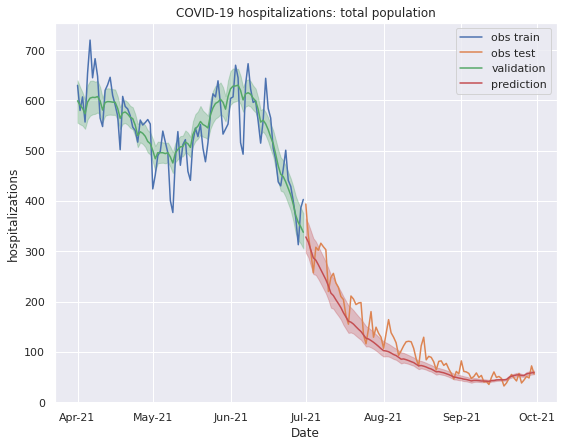

In [168]:
model.results_all_no_vac('entries_Hosp', t0_cases, tf_cases, t0_outcome, tf_outcome, t0_pred_outcome, tf_pred_outcome)

Estimated parameters (95% CI)
lambda: 0.135 (0.086, 0.193)
cor: 2.91 (2.78, 3.03)
phi: 27.16 (21.36, 33.44)

Mean time from cases to overcome:  7.71 days (HDI (95%) [4.73, 10.59])

CIR en Chile between 2021-03-01 and 2021-06-30: 2.91 %



<ipython-input-160-180998291986>:476: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  cor_hdi_1, cor_hdi_2 = az.hdi(model.fits_all[outcome_kind].extract()['cor'],hdi_prob=0.95)[0]*100


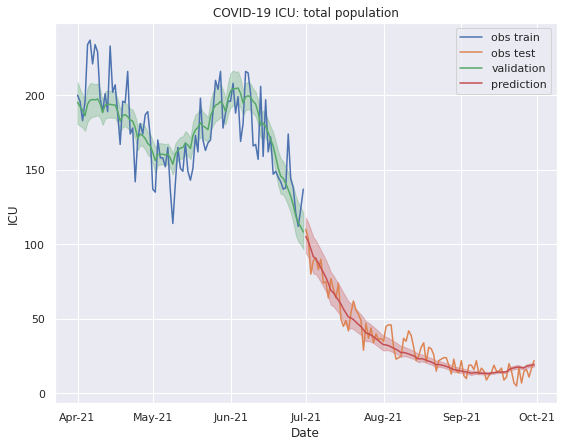

In [169]:
model.results_all_no_vac('entries_ICU', t0_cases, tf_cases, t0_outcome, tf_outcome, t0_pred_outcome, tf_pred_outcome)

Estimated parameters (95% CI)
lambda: 0.038 (0.026, 0.048)
cor: 2.46 (2.29, 2.66)
phi: 25.17 (19.19, 31.22)

Mean time from cases to overcome:  27.04 days (HDI (95%) [19.37, 35.06])

CFR en Chile between 2021-03-01 and 2021-06-30: 2.46 %



<ipython-input-160-180998291986>:476: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  cor_hdi_1, cor_hdi_2 = az.hdi(model.fits_all[outcome_kind].extract()['cor'],hdi_prob=0.95)[0]*100


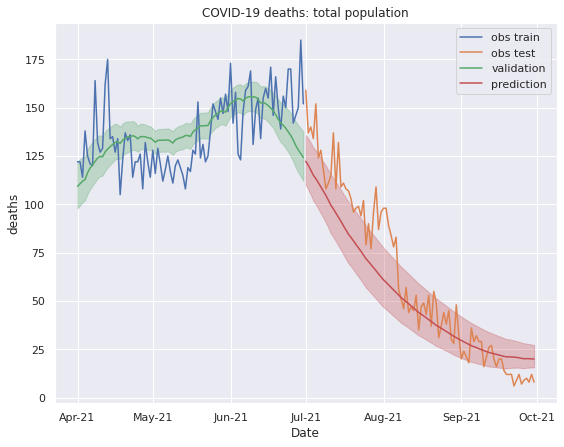

In [170]:
model.results_all_no_vac('deaths', t0_cases, tf_cases, t0_outcome, tf_outcome, t0_pred_outcome, tf_pred_outcome)

In [171]:
model.sample_all_vac('entries_Hosp', t0v_cases, tfv_cases, t0v_outcome, tfv_outcome)
model.sample_all_vac('entries_ICU', t0v_cases, tfv_cases, t0v_outcome, tfv_outcome)
model.sample_all_vac('deaths', t0v_cases, tfv_cases, t0v_outcome, tfv_outcome)

In [172]:
model.fits_all_vac['entries_Hosp'].extract()

OrderedDict([('RR',
              array([0.23953594, 0.26978218, 0.29646086, ..., 0.22238942, 0.29137937,
                     0.23217292])),
             ('gammaIntegrated',
              array([[4.46976898e-09, 5.06333322e-09, 5.73571998e-09, ...,
                      9.13541648e-02, 1.03485567e-01, 1.17227962e-01],
                     [4.46976898e-09, 5.06333322e-09, 5.73571998e-09, ...,
                      9.13541648e-02, 1.03485567e-01, 1.17227962e-01],
                     [4.46976898e-09, 5.06333322e-09, 5.73571998e-09, ...,
                      9.13541648e-02, 1.03485567e-01, 1.17227962e-01],
                     ...,
                     [4.46976898e-09, 5.06333322e-09, 5.73571998e-09, ...,
                      9.13541648e-02, 1.03485567e-01, 1.17227962e-01],
                     [4.46976898e-09, 5.06333322e-09, 5.73571998e-09, ...,
                      9.13541648e-02, 1.03485567e-01, 1.17227962e-01],
                     [4.46976898e-09, 5.06333322e-09, 5.73571998e-09,

Estimated RR:
RR: 21.3 (13.453, 29.921)

Effectiveness: 0.787087389616564



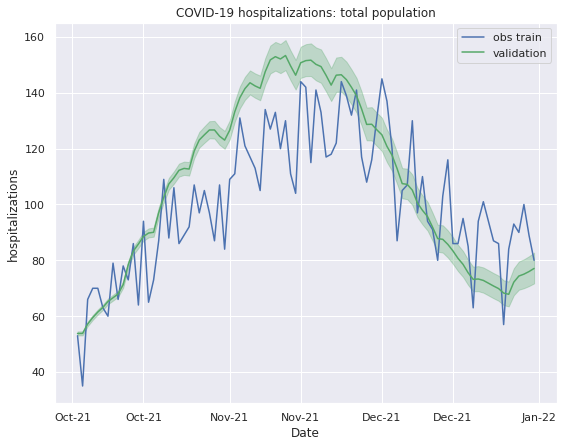

In [173]:
model.results_all_vac('entries_Hosp', t0v_cases, tfv_cases, t0v_outcome, tfv_outcome) 

Estimated RR:
RR: 1.4 (0.002, 4.151)

Effectiveness: 0.9855886686918546



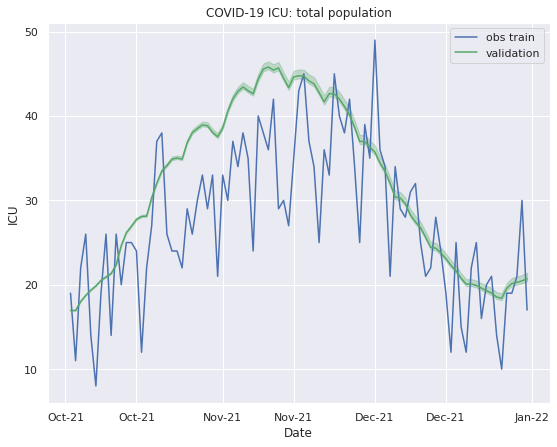

In [174]:
model.results_all_vac('entries_ICU', t0v_cases, tfv_cases, t0v_outcome, tfv_outcome) 

Estimated RR:
RR: 1.7 (0.002, 5.21)

Effectiveness: 0.9828153373883132



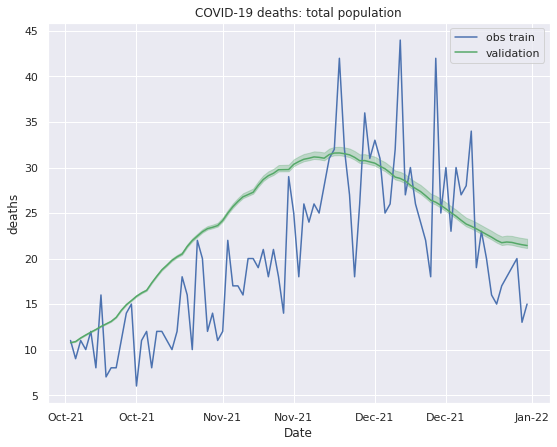

In [175]:
model.results_all_vac('deaths', t0v_cases, tfv_cases, t0v_outcome, tfv_outcome) 

Avoid respect model: 0.7407608958288396
Avoid respect data: 0.7302636309096545
Real outcomes: 9154
Estimated outcomes: 33936.84
Total avoid outcomes: 24782.839999999997
Total population proportion: 0.0012593954080428334



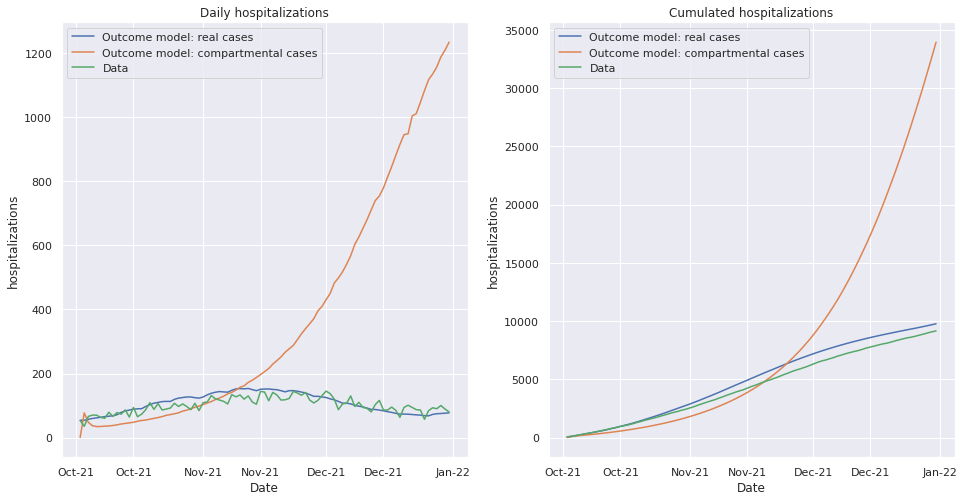

In [176]:
model.simulate_outcome('entries_Hosp', t0sim_cases, tfsim_cases, t0sim_outcome, tfsim_outcome, RR_aux=0.96)

Avoid respect model: 0.8276400981351335
Avoid respect data: 0.773450724853551
Real outcomes: 2502
Estimated outcomes: 11043.954999999998
Total avoid outcomes: 8541.954999999998
Total population proportion: 0.00043407853590260524



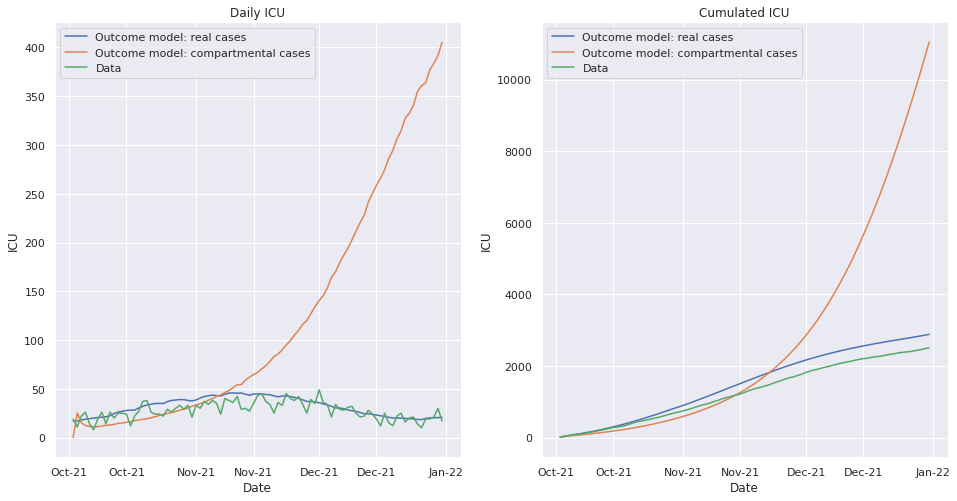

In [177]:
model.simulate_outcome('entries_ICU', t0sim_cases, tfsim_cases, t0sim_outcome, tfsim_outcome, RR_aux=0.01)

Avoid respect model: 0.8273025968312958
Avoid respect data: 0.7840394850937948
Real outcomes: 1840
Estimated outcomes: 8520.075999999997
Total avoid outcomes: 6680.075999999997
Total population proportion: 0.0003394629929328978



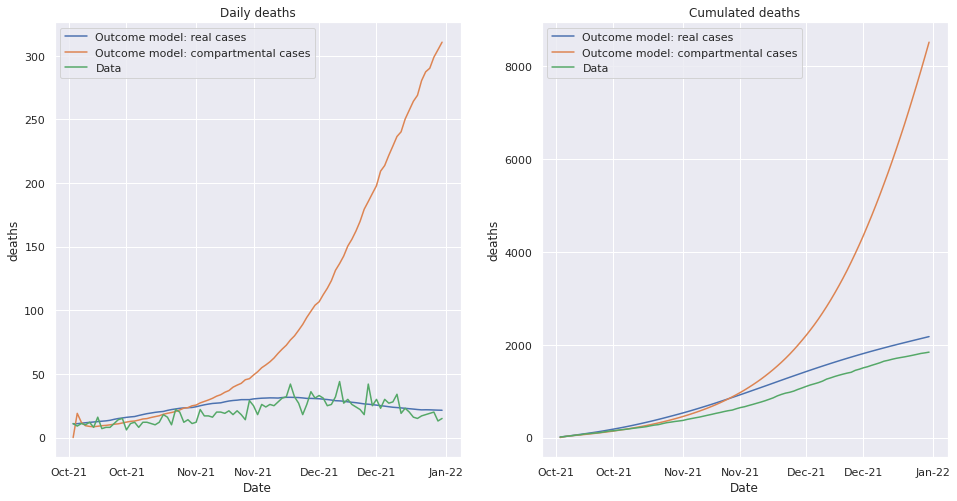

In [178]:
model.simulate_outcome('deaths', t0sim_cases, tfsim_cases, t0sim_outcome, tfsim_outcome, comparComp=False)

Avoid respect model: 0.8273361222104
Avoid respect data: 0.7842926604639865
Real outcomes: 1840
Estimated outcomes: 8530.076000000001
Total avoid outcomes: 6690.076000000001
Total population proportion: 0.00033997116528442943
Outcomes model - compartmental model: -272.92399999999907
Cuocient (outcomes model/compartmental): 0.9689964784732479



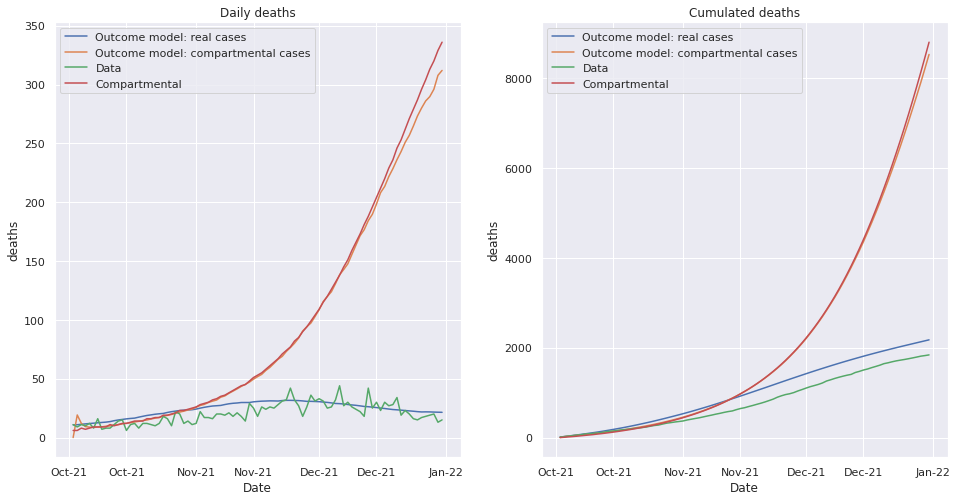

In [179]:
model.simulate_outcome('deaths', t0sim_cases, tfsim_cases, t0sim_outcome, tfsim_outcome)

In [180]:
model.sample_outcome_no_vac('entries_Hosp', t0_cases, tf_cases, t0_outcome, tf_outcome, t0_pred_outcome, tf_pred_outcome)
model.sample_outcome_no_vac('entries_ICU', t0_cases, tf_cases, t0_outcome, tf_outcome, t0_pred_outcome, tf_pred_outcome)
model.sample_outcome_no_vac('deaths', t0_cases, tf_cases, t0_outcome, tf_outcome, t0_pred_outcome, tf_pred_outcome)

<ipython-input-160-180998291986>:101: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  outcome_age[date] = outcome_data[outcome_data['date']==date].groupby('age_group', sort=False).sum()['quantity'].to_numpy()
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Mean time from cases to overcome:  6.49 days (HDI (95%) [5.36, 7.69])

CHR en Chile between 2021-03-01 and 2021-06-30: 9.61 %



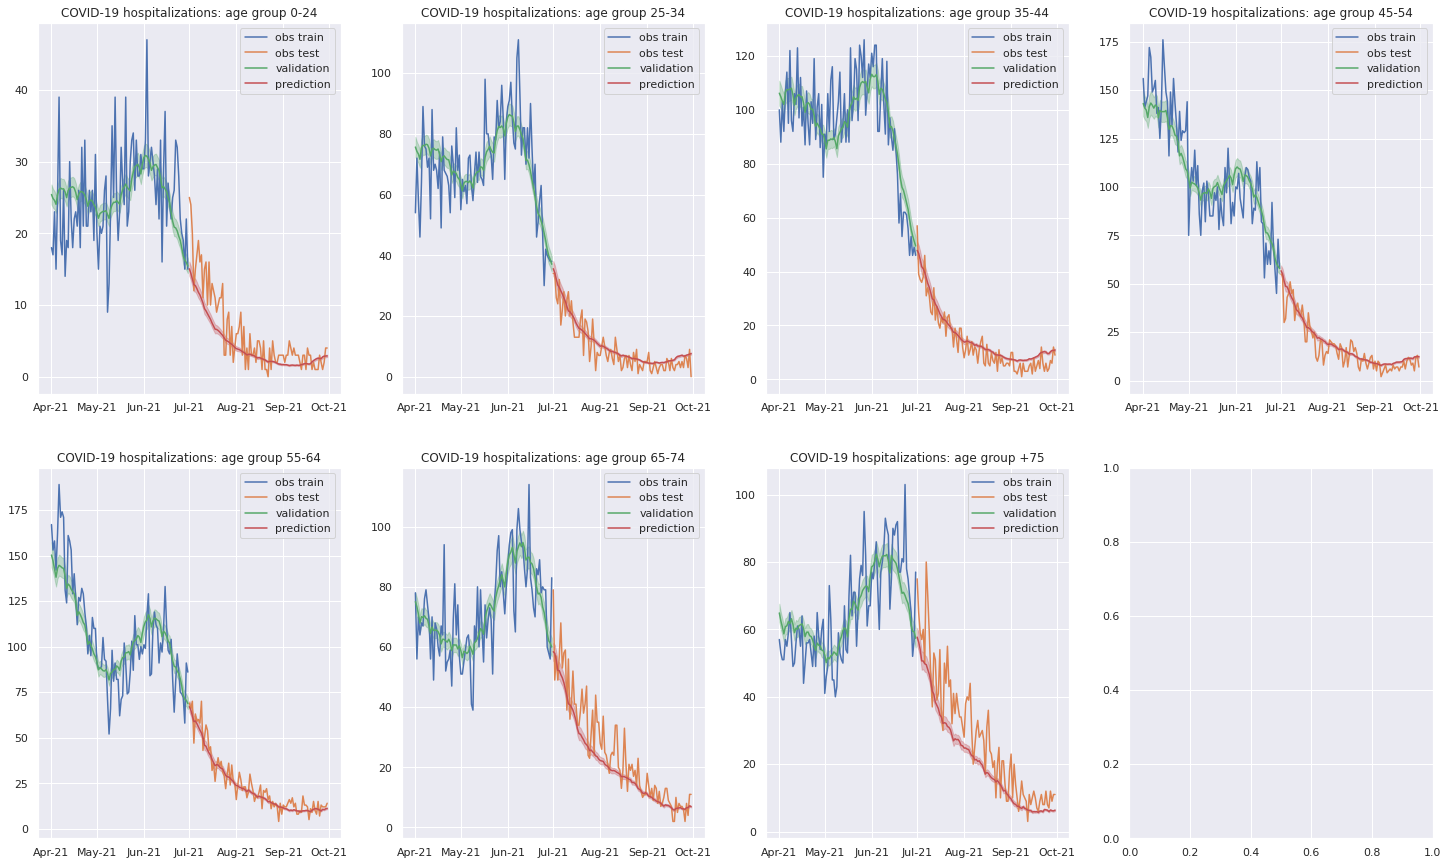

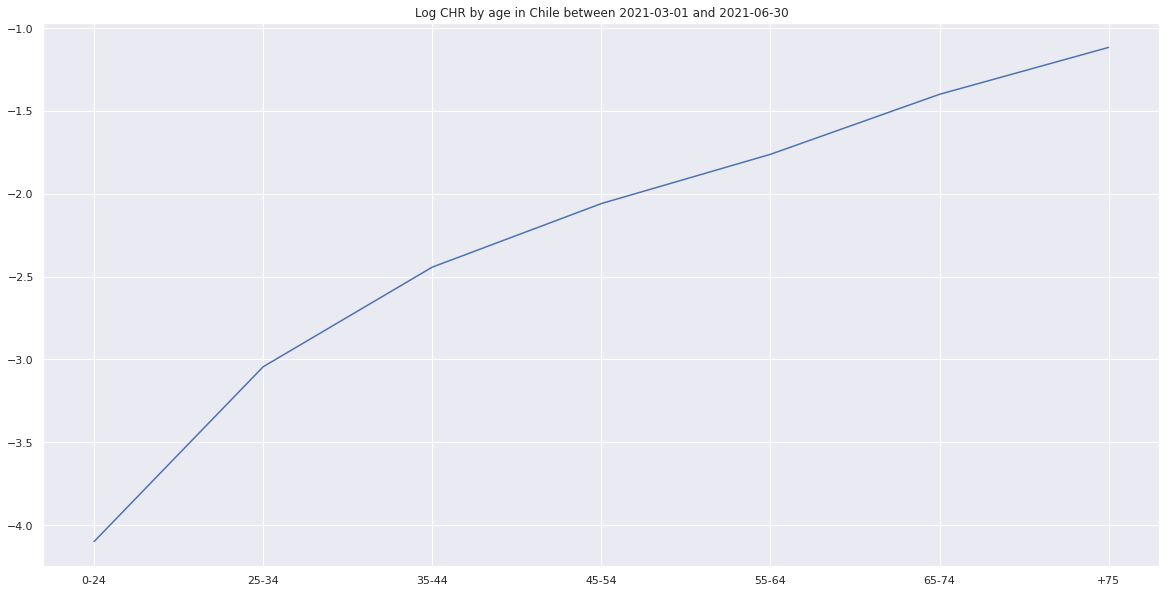

In [181]:
model.results_no_vac('entries_Hosp', t0_cases, tf_cases, t0_outcome, tf_outcome, t0_pred_outcome, tf_pred_outcome)

Mean time from cases to overcome:  6.97 days (HDI (95%) [5.43, 8.66])

CIR en Chile between 2021-03-01 and 2021-06-30: 3.04 %



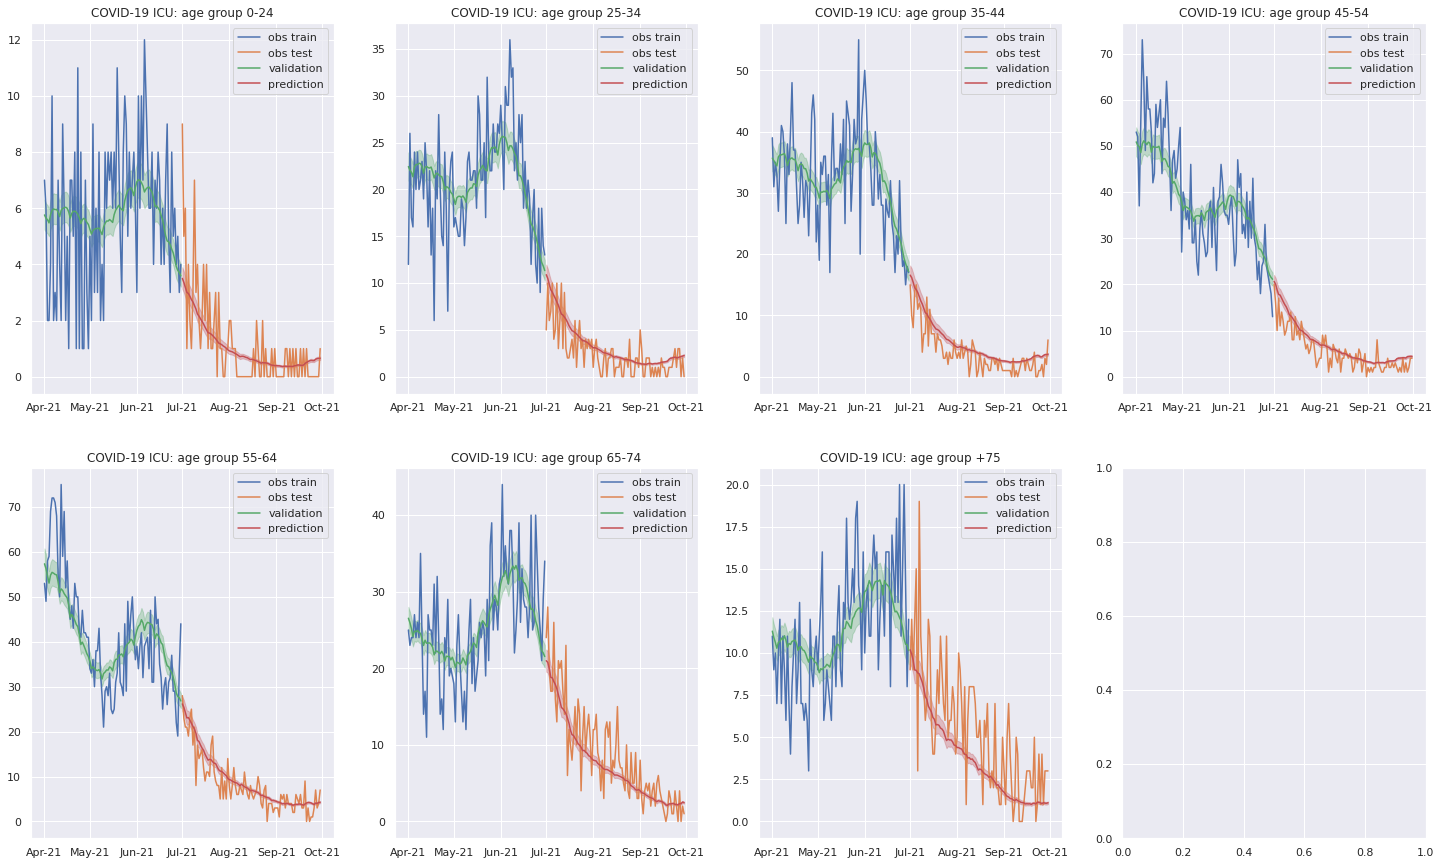

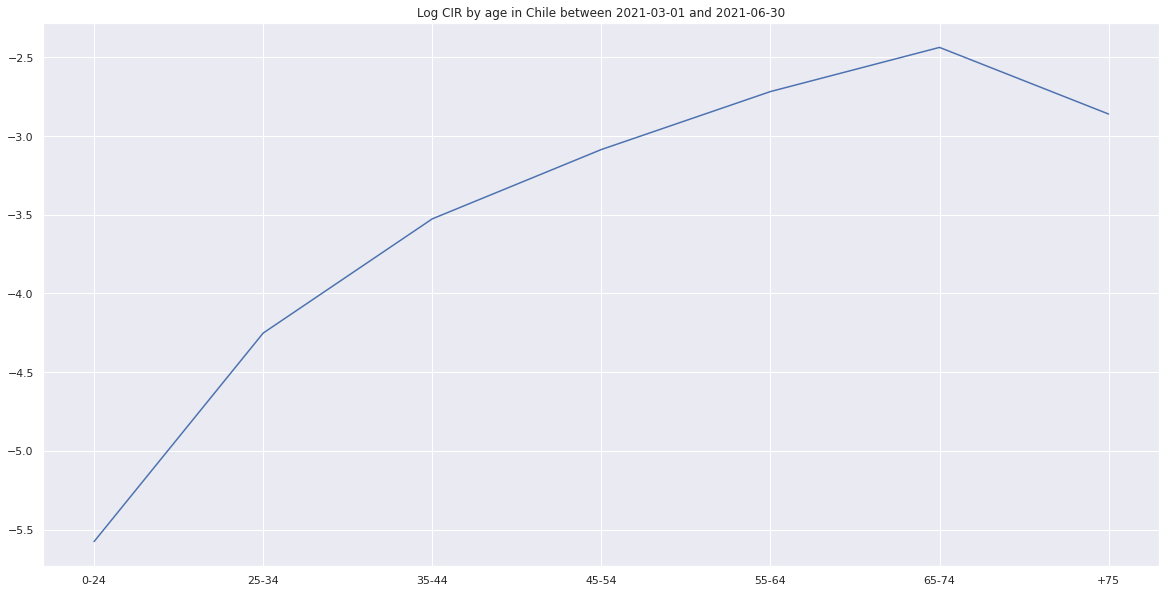

In [182]:
model.results_no_vac('entries_ICU', t0_cases, tf_cases, t0_outcome, tf_outcome, t0_pred_outcome, tf_pred_outcome)

Mean time from cases to overcome:  25.14 days (HDI (95%) [20.47, 29.85])

CFR en Chile between 2021-03-01 and 2021-06-30: 3.34 %



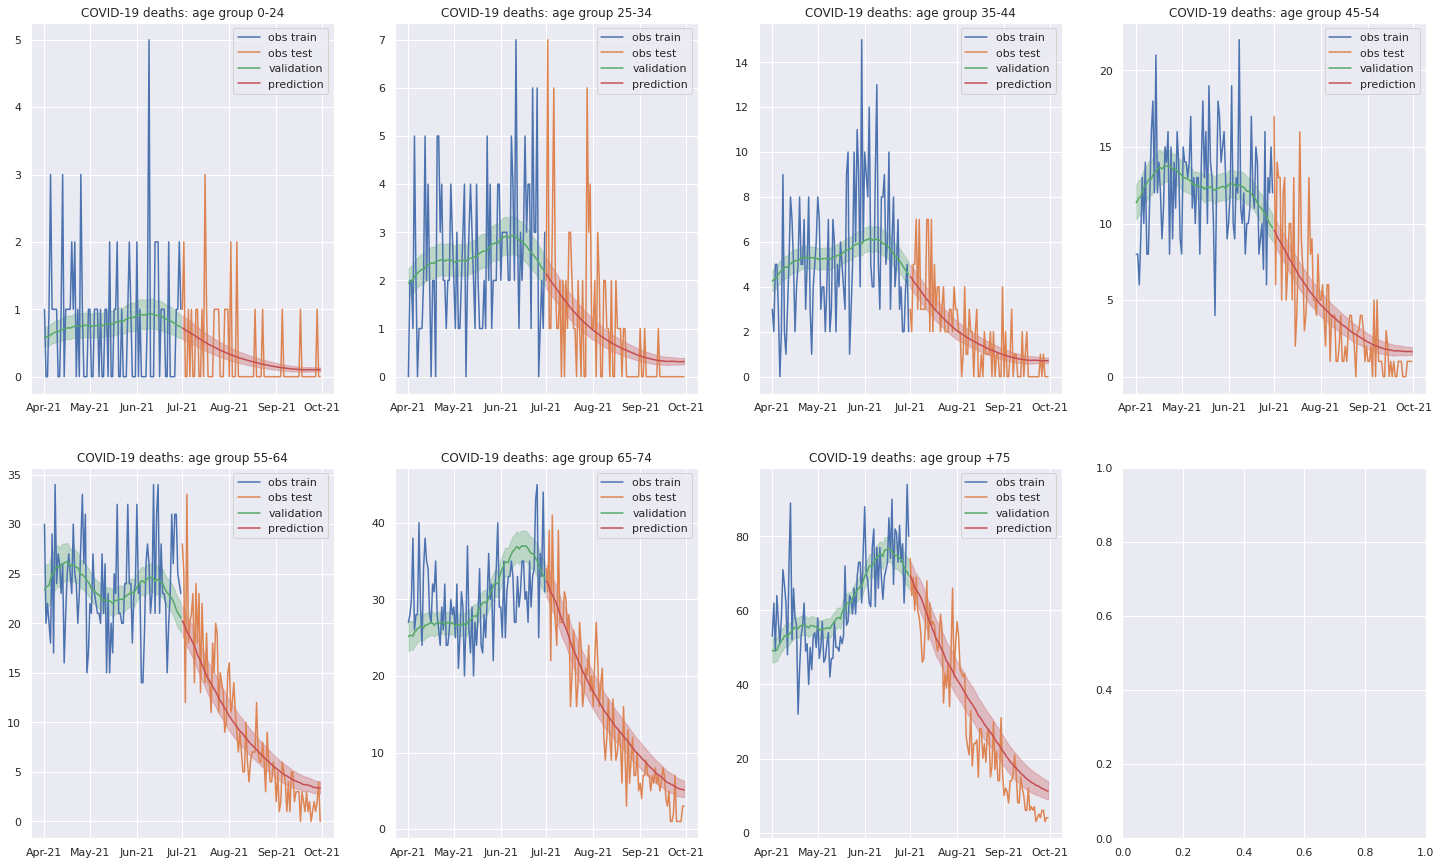

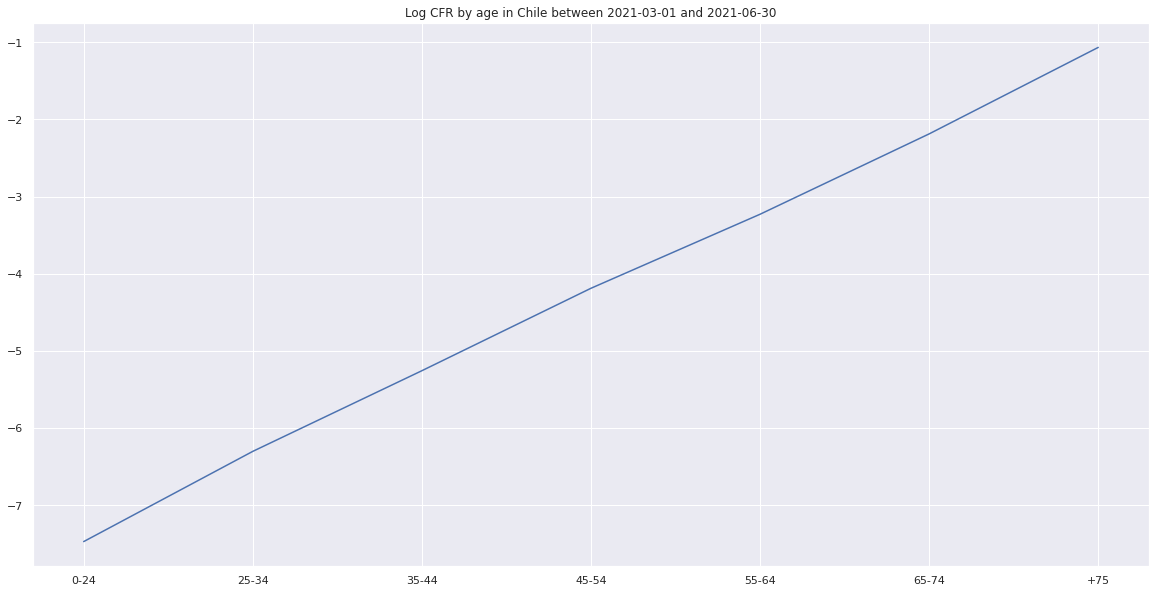

In [183]:
model.results_no_vac('deaths', t0_cases, tf_cases, t0_outcome, tf_outcome, t0_pred_outcome, tf_pred_outcome)

In [184]:
model.sample_outcome_vac('entries_Hosp', t0v_cases, tfv_cases, t0v_outcome, tfv_outcome)
model.sample_outcome_vac('entries_ICU', t0v_cases, tfv_cases, t0v_outcome, tfv_outcome)
model.sample_outcome_vac('deaths', t0v_cases, tfv_cases, t0v_outcome, tfv_outcome)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


<ipython-input-160-180998291986>:368: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  ve_ic = (1 - az.hdi(rr_samples, hdi_prob=0.95))*100


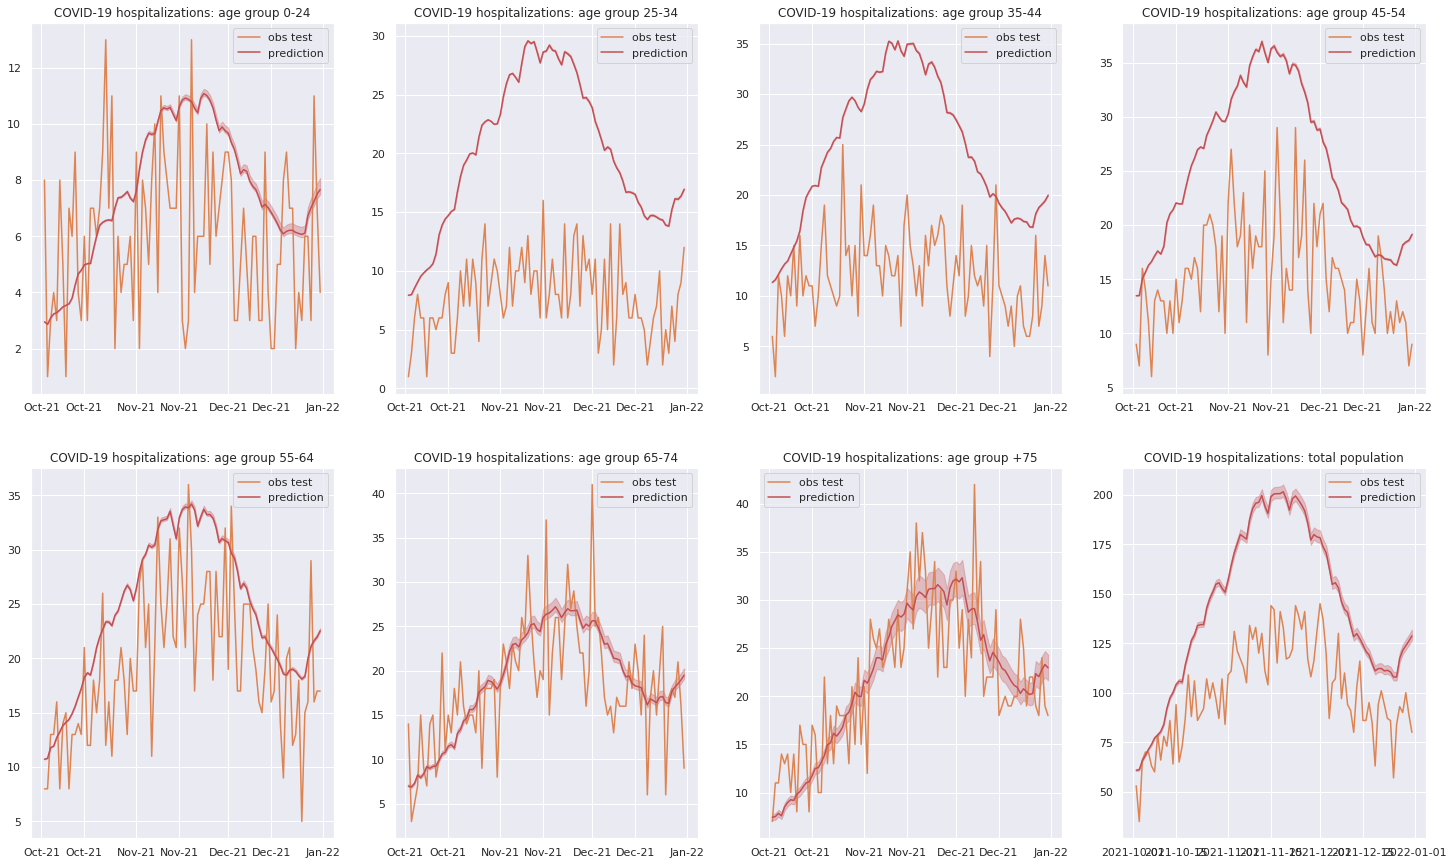

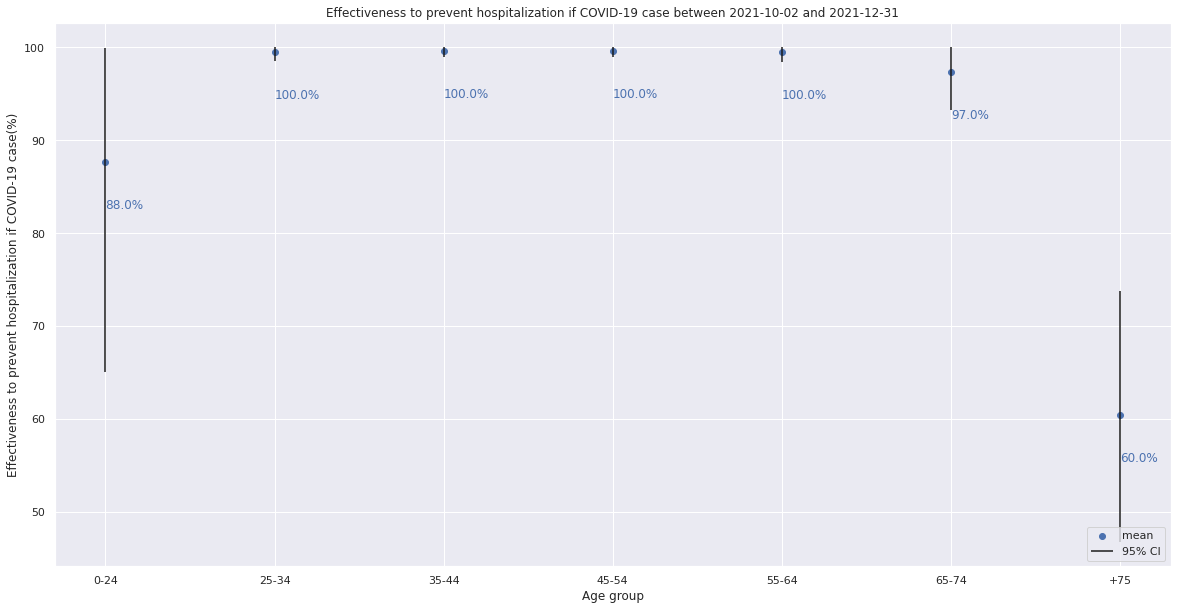

In [185]:
model.results_vac('entries_Hosp', t0v_cases, tfv_cases, t0v_outcome, tfv_outcome) 

<ipython-input-160-180998291986>:368: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  ve_ic = (1 - az.hdi(rr_samples, hdi_prob=0.95))*100


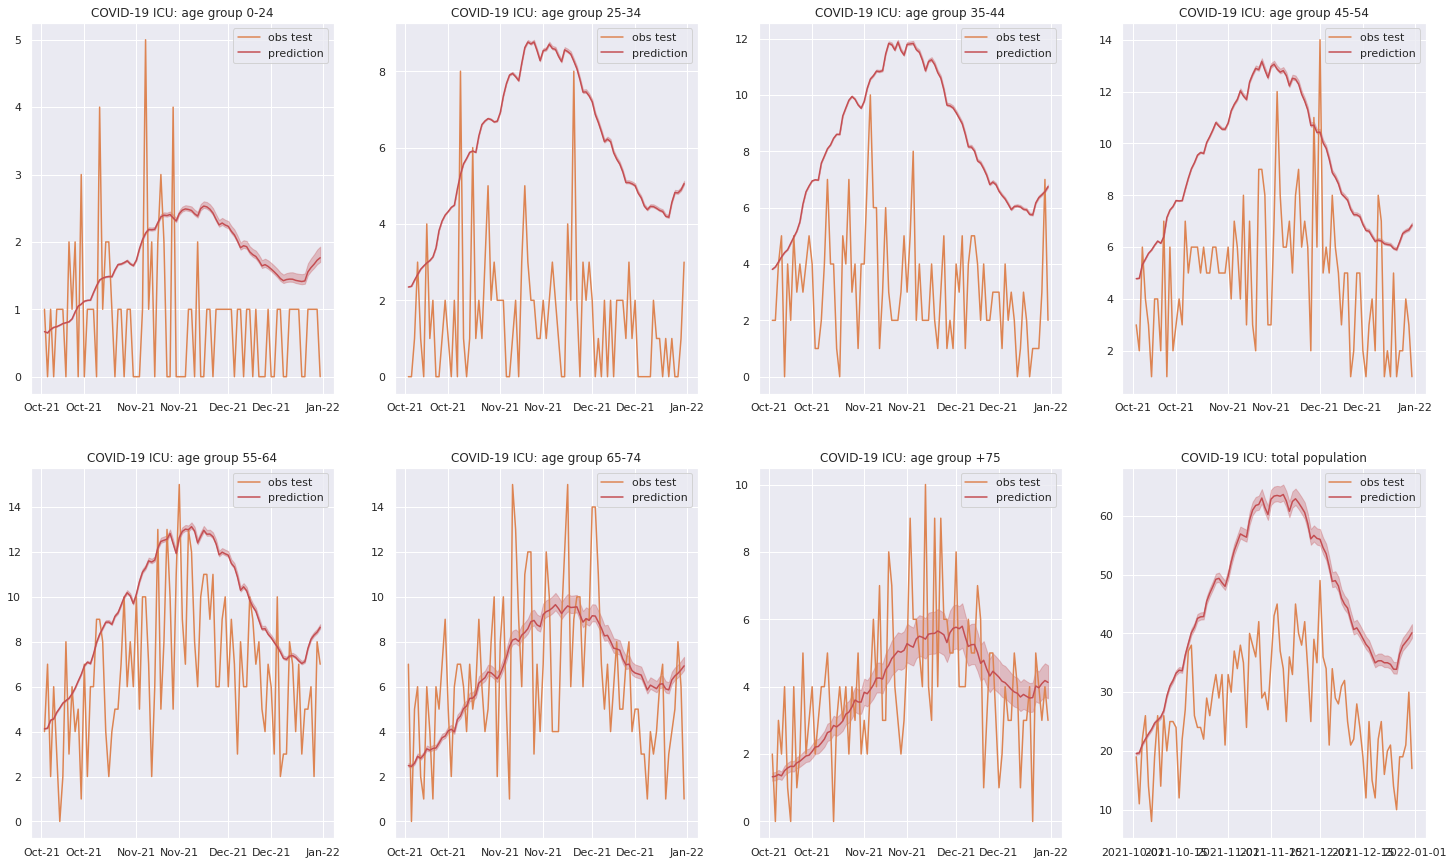

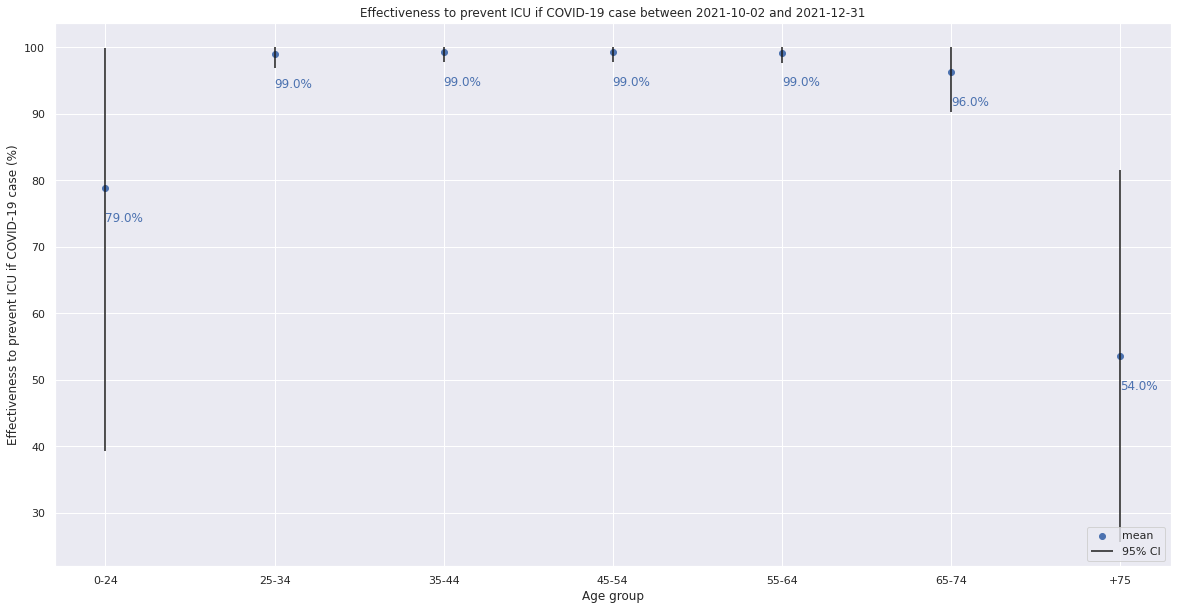

In [186]:
model.results_vac('entries_ICU', t0v_cases, tfv_cases, t0v_outcome, tfv_outcome) 

<ipython-input-160-180998291986>:368: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  ve_ic = (1 - az.hdi(rr_samples, hdi_prob=0.95))*100


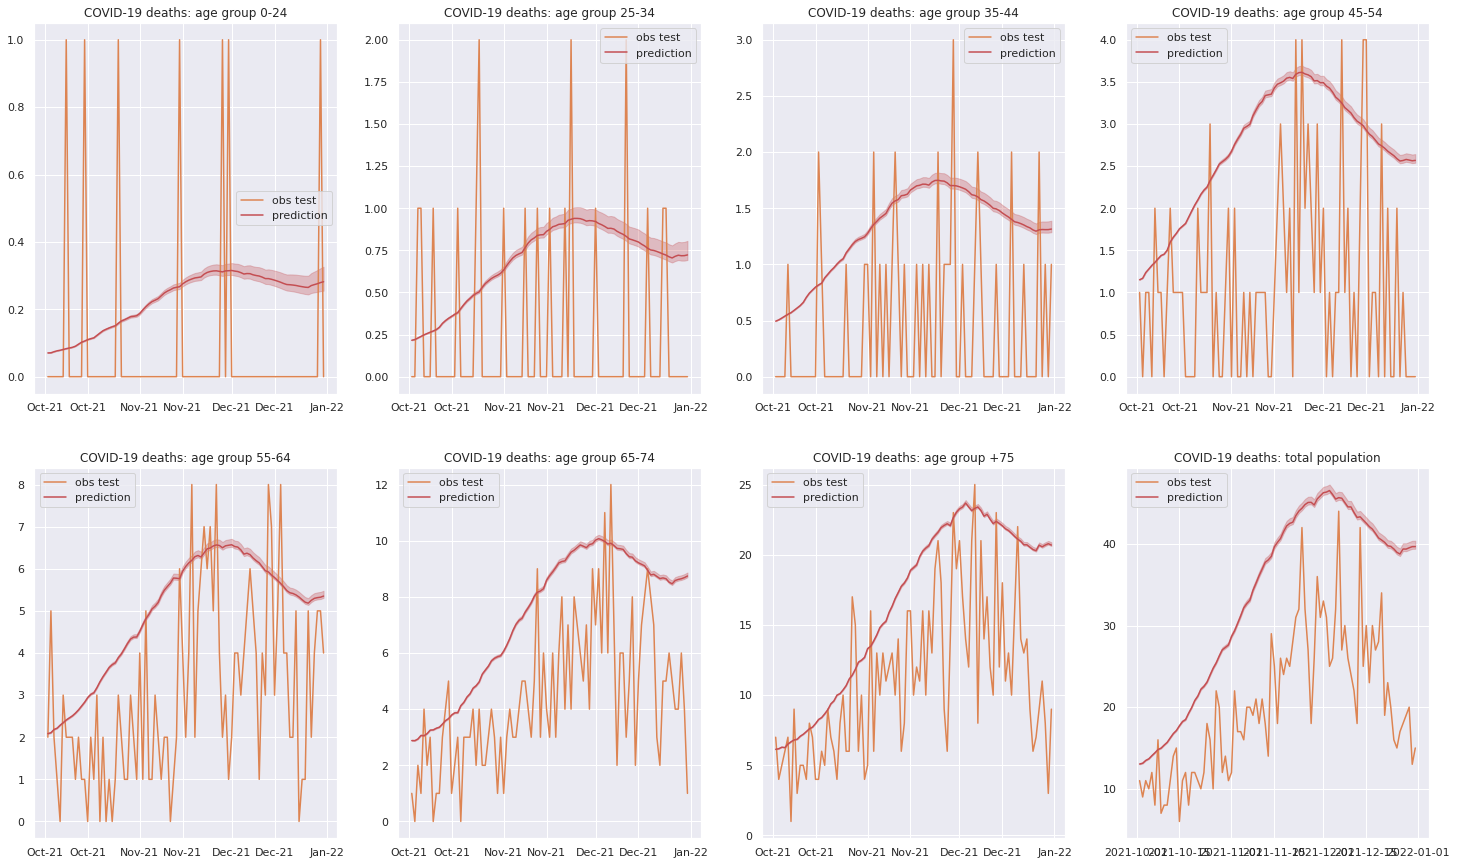

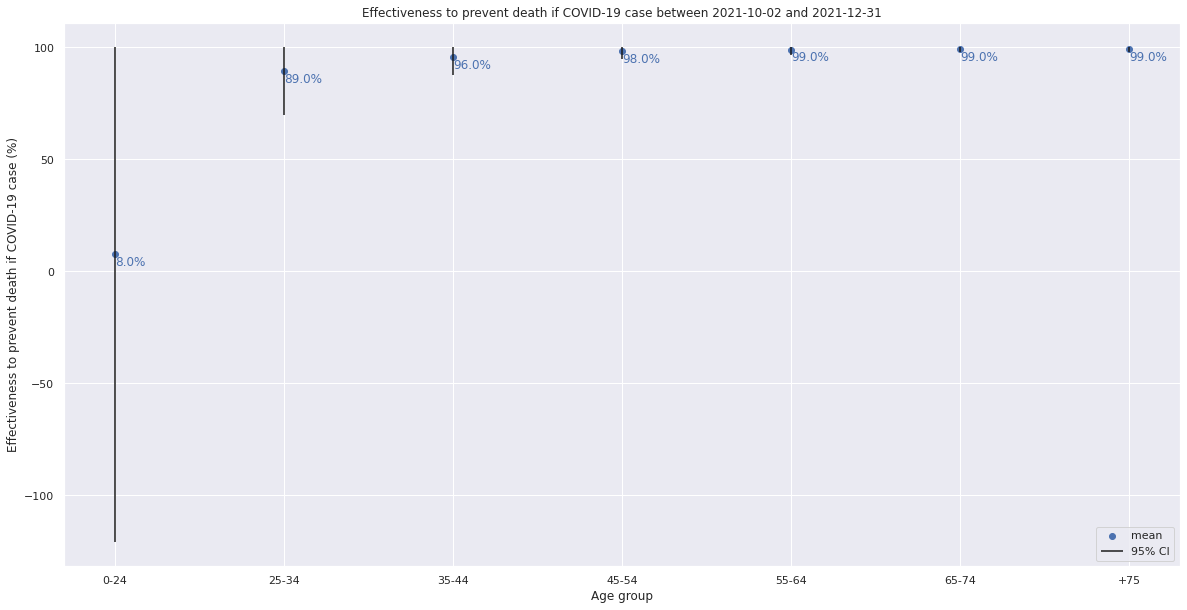

In [187]:
model.results_vac('deaths', t0v_cases, tfv_cases, t0v_outcome, tfv_outcome) 